# Método de compresión de imágenes basado en PCA
**Yamil Ernesto Morfa Avalos**


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib import image
import os

In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!tar -xf images.tar.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  19.0M      0  0:00:39  0:00:39 --:--:-- 19.6M


In [ ]:
base_dir = '/content/drive/MyDrive/tarea_8'
input_dir = "images/"
target_dir = "annotations/trimaps"
img_size = (160, 160) ## Dimansión para entrenar


input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

print("Number of samples:", len(input_img_paths))


Number of samples: 7390


Trabajaremos con el conjunto de imagenes Pets 

None
(160, 160)
RGB


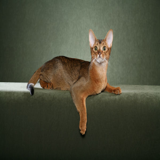

In [ ]:
img = Image.open(input_img_paths[0])
img = img.resize(img_size)
print(img.format)
print(img.size)
print(img.mode)
img

In [ ]:
M = 100
I = []
for path in input_img_paths[0:M]:
  img = Image.open(path)
  img = img.resize(img_size)
  I.append(np.array(img))
I = np.array(I)

In [ ]:
I.shape

(100, 160, 160, 3)

In [ ]:
def get_parches(m, l):
  parches = []
  for _ in range(m):
    select_img = np.random.randint(0, M, 1)[0]
    select_channel = np.random.randint(0,3,1)[0]
    i, j = np.random.randint(0, img_size[0]-l ,2)
    parche = I[select_img, i:(i+l), j:(j+l), select_channel]
    parches.append(parche)
  return np.array(parches)

In [ ]:
m=100
l = 32
parches = get_parches(m, l)

In [ ]:
parches.shape

(100, 32, 32)

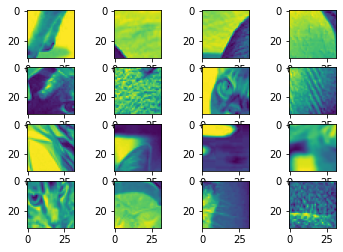

In [ ]:
fig, axs = plt.subplots(4,4)
axs[0,0].imshow(parches[2]), axs[0,1].imshow(parches[3]), axs[0,2].imshow(parches[4]), axs[0,3].imshow(parches[5])
axs[1,0].imshow(parches[18]), axs[1,1].imshow(parches[19]), axs[1,2].imshow(parches[20]), axs[1,3].imshow(parches[21])
axs[2,0].imshow(parches[34]), axs[2,1].imshow(parches[35]), axs[2,2].imshow(parches[36]), axs[2,3].imshow(parches[37])
axs[3,0].imshow(parches[50]), axs[3,1].imshow(parches[51]), axs[3,2].imshow(parches[52]), axs[3,3].imshow(parches[53])
plt.show()

Ahora preparemos la metriz de datos de la forma:
$$ X=\left[\begin{array}{c}
x_{1}^{T}\\
x_{2}^{T}\\
\vdots\\
x_{m}^{T}
\end{array}\right]$$ donde $x_{i}^{T}$ es el $i$-esimo parche reformado como un vector de $l*l$

In [ ]:
X = np.empty((m, l*l ))
for i in range(m):
    X[i,:] = parches[i,:,:].reshape(-1) 

In [ ]:
X.shape

(100, 1024)

Ahora calculemos las componentes princilpales de la matriz de datos $X$. Antes es importante  centrar los datos.

In [ ]:
def svd(X):
    X = X - np.mean(X, axis=0)
    cov = X.T@X ## Matriz de covarianza X'X
    eig = np.linalg.eig(cov) ## Usamos la funcion de numpy para encontrar los valores y vectores propios
    eigvals = np.sort(eig[0])[::-1] ## Ordenamos los valores propios de mayor a menor. 
    U = np.empty_like(eig[1])

    for i, eigval  in enumerate(eigvals): ## Creamos la matriz correspondiente a los eigvectores ordenados
        index = np.where(eig[0] == eigval)[0]
        U[:,i] = eig[1][:,index].reshape(-1)
    return U, eigvals

In [ ]:
U, eigvals = svd(X) ### los valors los debuelve en complejos, con parte imaginaria 0
U = np.array(U, float)
eigvals = np.array(eigvals, float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


Tenemos $U = \left[u_{1},\,u_{2},\, ...,\, u_{m} \right]$ los eigenvectores coerrespondientes a $X^{T}X$ y sus eigenvalores  $\left[ \lambda_{1}, \lambda_{2}, ..., \lambda_{m}\right]$. Entonces seleccionamos los $K$ primeros eigenvalores e eigenvectores asosiados, con $K$ tal qué:
$$ K = \arg\inf_{k} \left( \sum_{i=1}^{k} \lambda_i \geq\theta\sum_{i=1}^{m} \lambda_i \right)$$ luego se construye la matriz 
$$\bar{U} = \left[u_{1},\,u_{2},\, ...,\, u_{K} \right]$$

In [ ]:
U.shape

(1024, 1024)

In [ ]:
def get_k(theta):
    aux = theta*np.sum(eigvals)
    aux_1 = []
    for k in range(len(eigvals)):
        aux_1.append(np.sum(eigvals[0:k+1]))
    aux_1 = np.array(aux_1)
    return np.where(aux_1>=aux)[0][0]
index = get_k(0.999)
U_bar = U[:,:index+1]

In [ ]:
index

75

In [ ]:
U_bar.shape

(1024, 76)

Obtengamos el conjunto de prueba $J$

In [ ]:
J = []
N = 10
for path in input_img_paths[M:M+N]:
  img = Image.open(path)
  img = img.resize(img_size)
  J.append(np.array(img))
J = np.array(J)

In [ ]:
J.shape

(10, 160, 160, 3)

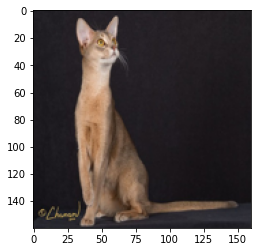

In [ ]:
plt.imshow(J[0])
plt.show()

 Para el conjunto de imágenes de prueba $J$ calculemos los coeficientes en el espacio de dimensión comprimido para cada bloque no solapado de $\left(l, l \right)$:
 $$ \beta_{i} = \bar{U}^{T}x_{i}$$ con $x_{i}$ la matriz de parches del canal $i$ de $J$ 

In [ ]:
### Bloques no solapados con 3 canales
parches_J = []
for im_inx in range(N):
  for i in range(5):
    for j in range(5):
        sub_img = J[im_inx, 32*i:32*(i+1), 32*j:32*(j+1)]
        parches_J.append(sub_img)
parches_J = np.array(parches_J)

In [ ]:
parches_J.shape

(250, 32, 32, 3)

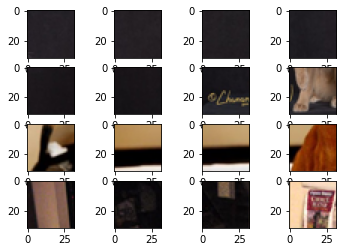

In [ ]:
fig, axs = plt.subplots(4,4)
axs[0,0].imshow(parches_J[2]), axs[0,1].imshow(parches_J[3]), axs[0,2].imshow(parches_J[4]), axs[0,3].imshow(parches_J[5])
axs[1,0].imshow(parches_J[18]), axs[1,1].imshow(parches_J[19]), axs[1,2].imshow(parches_J[20]), axs[1,3].imshow(parches_J[21])
axs[2,0].imshow(parches_J[34]), axs[2,1].imshow(parches_J[35]), axs[2,2].imshow(parches_J[36]), axs[2,3].imshow(parches_J[37])
axs[3,0].imshow(parches_J[50]), axs[3,1].imshow(parches_J[51]), axs[3,2].imshow(parches_J[52]), axs[3,3].imshow(parches_J[53])
plt.show()

In [ ]:
X_j = parches_J.reshape((5*5*N, l*l,3))

In [ ]:
X_j.shape

(250, 1024, 3)

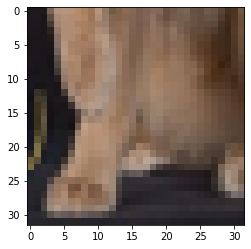

In [ ]:
plt.imshow(X_j[21].reshape((l,l,3)))
plt.show()

In [ ]:
U_bar.T.shape

(76, 1024)

In [ ]:
beta_0 = U_bar.T @ X_j.T[0]
beta_1 = U_bar.T @ X_j.T[1]
beta_2 = U_bar.T @ X_j.T[2]

In [ ]:
beta_1.shape

(76, 250)

Para guardar el conjunto de imagenes $J$, ecesitabamos espacio para $10\times160\times160\times3 = 768,000$, ahora obtenidos los coeficientes $\beta_{i}$ solo encesitamos para almacenar nuestras imagenes $250\times76\times3 + 76\times1024 = 134,824$

Veamos si podemos recuperar las imagenes.
$$\bar{x}_{i} = \bar{U}\beta_{i}$$

In [ ]:
X_bar_j = np.empty_like(X_j.T )

X_bar_j[0] = U_bar @ beta_0
X_bar_j[1] = U_bar @ beta_1
X_bar_j[2] = U_bar @ beta_2

In [ ]:
X_bar_j.shape

(3, 1024, 250)

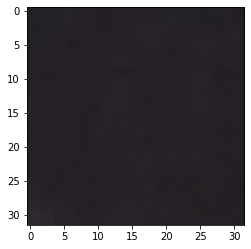

In [ ]:
plt.imshow(X_bar_j.T[2].reshape((l,l,3)))

In [ ]:
parches_J_bar = []
for i in range(5*5*N):
  parches_J_bar.append( X_bar_j.T[i].reshape((l,l,3)))
parches_J_bar = np.array(parches_J_bar)

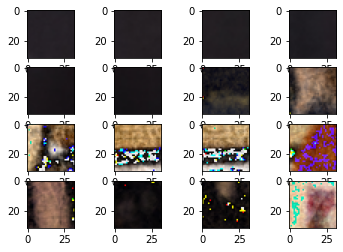

In [ ]:
fig, axs = plt.subplots(4,4)
axs[0,0].imshow(parches_J_bar[2]), axs[0,1].imshow(parches_J_bar[3]), axs[0,2].imshow(parches_J_bar[4]), axs[0,3].imshow(parches_J_bar[5])
axs[1,0].imshow(parches_J_bar[18]), axs[1,1].imshow(parches_J_bar[19]), axs[1,2].imshow(parches_J_bar[20]), axs[1,3].imshow(parches_J_bar[21])
axs[2,0].imshow(parches_J_bar[34]), axs[2,1].imshow(parches_J_bar[35]), axs[2,2].imshow(parches_J_bar[36]), axs[2,3].imshow(parches_J_bar[37])
axs[3,0].imshow(parches_J_bar[50]), axs[3,1].imshow(parches_J_bar[51]), axs[3,2].imshow(parches_J_bar[52]), axs[3,3].imshow(parches_J_bar[53])
plt.show()

In [ ]:
parches_J_bar.shape

(250, 32, 32, 3)

In [ ]:
J_bar = np.empty_like(J)
c=0
for im_inx in range(N):
  for i in range(5):
    for j in range(5):
        J_bar[im_inx, 32*i:32*(i+1), 32*j:32*(j+1),:] = parches_J_bar[c]
        c = c+1

In [ ]:
J_bar.shape

(10, 160, 160, 3)

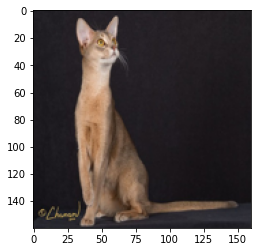

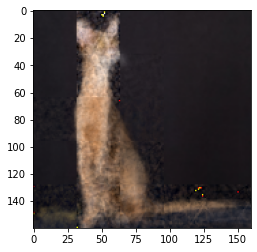

In [ ]:
plt.imshow(J[0])
plt.show()
plt.imshow(J_bar[0])
plt.show()

Arriba se muestra una imagen de prueba original y la recuperada, como podemos ver esta pierde un poco su calidad. Aumentemos el valor de $K$ y veamos que sucede

In [ ]:
def get_k(theta):
    aux = theta*np.sum(eigvals)
    for k in range(len(eigvals)):
        aux_1 = np.sum(eigvals[:k+1])
        if aux <= aux_1:
            index = k
            break
    return index

index = get_k(0.999999)
print(index + 1)
U_bar = U[:,:index+1]

U_bar = np.array(U_bar, float) ### los valors los debuelve en complejos, con parte imaginaria 0

beta_0 = U_bar.T @ X_j.T[0]
beta_1 = U_bar.T @ X_j.T[1]
beta_2 = U_bar.T @ X_j.T[2]

X_bar_j = np.empty_like(X_j.T )

X_bar_j[0] = U_bar @ beta_0
X_bar_j[1] = U_bar @ beta_1
X_bar_j[2] = U_bar @ beta_2

parches_J_bar = []
for i in range(5*5*N):
  parches_J_bar.append( X_bar_j.T[i].reshape((l,l,3)))
parches_J_bar = np.array(parches_J_bar)

J_bar = np.empty_like(J)
c=0
for im_inx in range(N):
  for i in range(5):
    for j in range(5):
        J_bar[im_inx, 32*i:32*(i+1), 32*j:32*(j+1),:] = parches_J_bar[c]
        c = c+1

98


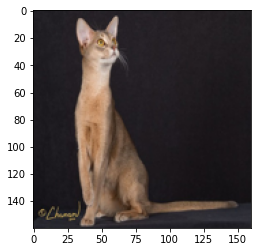

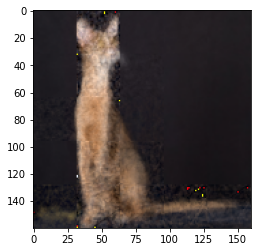

In [ ]:
plt.imshow(J[0])
plt.show()
plt.imshow(J_bar[0])
plt.show()

Ahora fijemos un pixel determinado, $p$, y veamos como varia: $$MAE_{\theta} = \frac{1}{N}\sum_{j=1}^{N}\left| J_{i}\left(p\right) - \bar{J}_{i}^{\theta}\left(p\right) \right| $$ con respecto al parámetro $\theta$

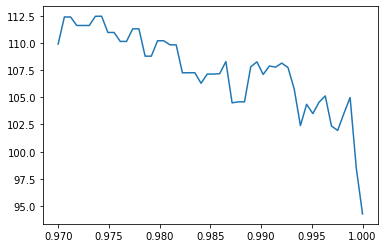

In [ ]:
mean_list = 0
pix = 50
for _ in range(pix):
  p = np.random.randint(0,160,2) ## un pixel aleatorio
  theta = np.linspace(0.97,1)
  lista = []
  for i in theta:
    index = get_k(i)
  
    U_bar = U[:,:index+1]
    beta_0 = U_bar.T @ X_j.T[0]
    beta_1 = U_bar.T @ X_j.T[1]
    beta_2 = U_bar.T @ X_j.T[2]

    X_bar_j = np.empty_like(X_j.T )

    X_bar_j[0] = U_bar @ beta_0
    X_bar_j[1] = U_bar @ beta_1
    X_bar_j[2] = U_bar @ beta_2

    parches_J_bar = []
    for i in range(5*5*N):
      parches_J_bar.append( X_bar_j.T[i].reshape((l,l,3)))
    parches_J_bar = np.array(parches_J_bar)

    J_bar = np.empty_like(J)
    c=0
    for im_inx in range(N):
      for i in range(5):
        for j in range(5):
          J_bar[im_inx, 32*i:32*(i+1), 32*j:32*(j+1),:] = parches_J_bar[c]
          c = c+1
  
    lista.append(np.mean(np.abs(J[:,p[0],p[1]] - J_bar[:,p[0],p[1]])))
  mean_list = mean_list + np.array(lista)
  
plt.plot(theta, mean_list/pix)
plt.show()